# DeepShot: Player Embedding Model

## Introduction

While our spatial model provides a strong foundation for shot prediction, it treats all players the same. In reality, different players have vastly different shooting abilities and tendencies - Stephen Curry and Shaquille O'Neal don't have the same shooting profile, even from identical court locations.

In this notebook, we develop a player embedding model to capture these player-specific shooting patterns. Player embeddings are a technique inspired by natural language processing, where we represent each player as a continuous vector in a high-dimensional space. Players with similar shooting tendencies will be positioned close to each other in this embedding space.

Our approach involves:

1. **Creating a Player Dictionary**: Assigning a unique ID to each player
2. **Building an Embedding Layer**: Learning a vector representation for each player
3. **Combining with Spatial Features**: Integrating player embeddings with court location data
4. **Training the Model**: Learning player-specific shooting patterns
5. **Extracting Embeddings**: Analyzing the learned player representations
6. **Visualizing Player Similarities**: Mapping players in 2D space based on shooting tendencies

This player embedding approach allows us to capture latent shooting characteristics that aren't explicitly encoded in our features, such as shooting form, release speed, and decision-making tendencies. The resulting embeddings provide a mathematical representation of each player's "shooting DNA."

In [2]:
# ##HIDE##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, classification_report

# Set visualization style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

# Create directories
processed_dir = Path('../data/processed')
features_dir = processed_dir / 'features'
models_dir = Path('../models')
player_embedding_dir = models_dir / 'player_embedding'

for directory in [processed_dir, features_dir, models_dir, player_embedding_dir]:
    directory.mkdir(parents=True, exist_ok=True)

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.15.0
GPU available: []


## Data Preparation

Before building our embedding model, we need to prepare our data appropriately. This includes creating a player dictionary that maps player names to unique IDs, selecting relevant features, and splitting the data for training and evaluation.

In [3]:
# Load shot data with features
shots = pd.read_csv(features_dir / 'shots_with_features.csv')
print(f"Loaded {len(shots)} shots")

# Create player dictionary
player_encoder = LabelEncoder()
player_ids = player_encoder.fit_transform(shots['player_name'].unique())
player_names = shots['player_name'].unique()
player_dict = dict(zip(player_names, player_ids))
id_to_player_dict = dict(zip(player_ids, player_names))

print(f"Created player dictionary with {len(player_dict)} players")

# Add player IDs to shot features
shots['player_id'] = shots['player_name'].map(player_dict)
shots['player_id'] = shots['player_id'].astype(int)

# Save player dictionary for later use
player_dict_df = pd.DataFrame({
    'player_name': player_names,
    'player_id': player_ids
})
player_dict_df.to_csv(processed_dir / 'player_dict.csv', index=False)

Loaded 4650091 shots
Created player dictionary with 2164 players


In [4]:
# Select relevant features for the embedding model
embedding_features = ['player_id', 'loc_x', 'loc_y', 'shot_distance', 'shot_angle', 'shot_made']
embedding_data = shots[embedding_features].copy()

# Drop rows with missing values
embedding_data = embedding_data.dropna()

# Define features and target
X = embedding_data.drop('shot_made', axis=1)
y = embedding_data['shot_made']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 2976057 samples
Validation set: 744015 samples
Testing set: 930019 samples


## Player Shot Pattern Analysis

To understand the variation in player shooting patterns, we'll analyze shot success rates and distributions across different players. This analysis will help us understand the player-specific patterns we're trying to capture with our embedding model.

In [5]:
# Calculate shot success rate by player
player_shot_stats = shots.groupby('player_name').agg(
    total_shots=('shot_made', 'count'),
    made_shots=('shot_made', 'sum'),
    success_rate=('shot_made', 'mean')
).reset_index()

# Sort by total shots
player_shot_stats = player_shot_stats.sort_values('total_shots', ascending=False)

# Display top players by total shots
player_shot_stats.head(10)

,player_name,total_shots,made_shots,success_rate
1304,LEBRON JAMES,29311,14837,0.506192
283,CARMELO ANTHONY,24144,10803,0.447440
1789,RUSSELL WESTBROOK,21648,9486,0.438193
1214,KEVIN DURANT,20737,10433,0.503110
894,JAMES HARDEN,19039,8392,0.440779
617,DWYANE WADE,18297,8753,0.478384
571,DIRK NOWITZKI,18285,8637,0.472354
503,DEMAR DEROZAN,18006,8440,0.468733
1248,KOBE BRYANT,17869,7916,0.443002
2079,VINCE CARTER,17584,7568,0.430391


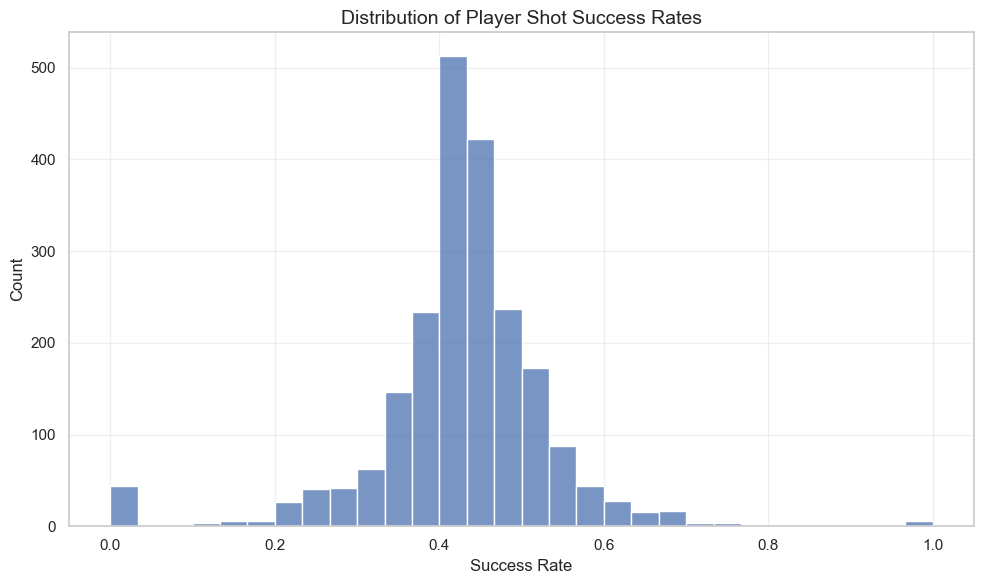

In [6]:
# Plot distribution of success rates
plt.figure(figsize=(10, 6))
sns.histplot(player_shot_stats['success_rate'], bins=30)
plt.title('Distribution of Player Shot Success Rates', fontsize=14)
plt.xlabel('Success Rate')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_80840/619678604.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  player_distance_dist = shots.groupby(['player_name', 'distance_bin']).size().unstack(fill_value=0)


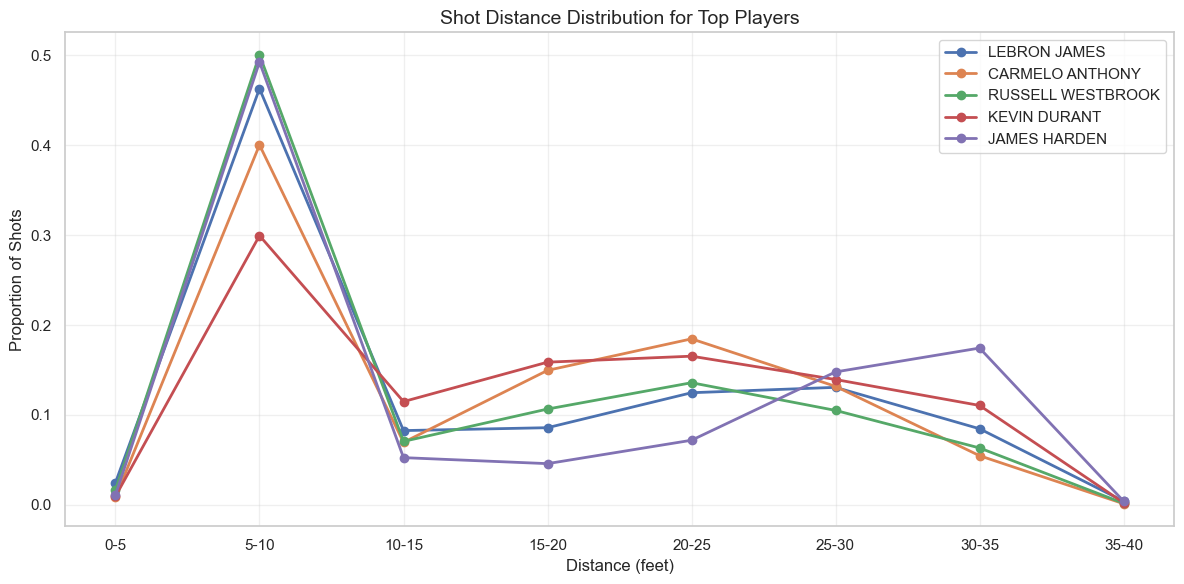

In [7]:
# Create distance bins
distance_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
distance_labels = [f"{distance_bins[i]}-{distance_bins[i+1]}" for i in range(len(distance_bins)-1)]

# Add distance bin column
shots['distance_bin'] = pd.cut(shots['shot_distance'], bins=distance_bins, labels=distance_labels)

# Calculate shot distribution by player and distance bin
player_distance_dist = shots.groupby(['player_name', 'distance_bin']).size().unstack(fill_value=0)

# Normalize by player
player_distance_dist = player_distance_dist.div(player_distance_dist.sum(axis=1), axis=0)

# Plot distance distributions for top players
top_players = player_shot_stats.head(5)['player_name'].tolist()

plt.figure(figsize=(12, 6))
for player in top_players:
    if player in player_distance_dist.index:
        plt.plot(player_distance_dist.columns, player_distance_dist.loc[player], marker='o', linewidth=2, label=player)

plt.title('Shot Distance Distribution for Top Players', fontsize=14)
plt.xlabel('Distance (feet)')
plt.ylabel('Proportion of Shots')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Embedding Model Architecture

Our player embedding model uses a neural network architecture with an embedding layer that learns a vector representation for each player. This embedding is then combined with spatial features to predict shot success. The architecture allows the model to learn player-specific shooting patterns while accounting for court location.

In [8]:
# Separate player IDs and other features
X_train_player_ids = X_train['player_id'].values.astype(int)
X_train_features = X_train.drop('player_id', axis=1).values

X_val_player_ids = X_val['player_id'].values.astype(int)
X_val_features = X_val.drop('player_id', axis=1).values

X_test_player_ids = X_test['player_id'].values.astype(int)
X_test_features = X_test.drop('player_id', axis=1).values

print(f"Player ID arrays shape: {X_train_player_ids.shape}, {X_val_player_ids.shape}, {X_test_player_ids.shape}")
print(f"Feature arrays shape: {X_train_features.shape}, {X_val_features.shape}, {X_test_features.shape}")

Player ID arrays shape: (2976057,), (744015,), (930019,)
Feature arrays shape: (2976057, 4), (744015, 4), (930019, 4)


In [9]:
# Define embedding dimension
embedding_dim = 32  # Adjust based on the number of players and complexity of patterns
num_players = len(player_dict)

# Define model parameters
hidden_units = [128, 64]  # Hidden layer sizes
dropout_rate = 0.3  # Dropout rate for regularization
l2_reg = 0.001  # L2 regularization strength

# Define input layers
player_input = keras.Input(shape=(1,), name='player_input')
features_input = keras.Input(shape=(X_train_features.shape[1],), name='features_input')

# Player embedding layer
player_embedding = layers.Embedding(
    input_dim=num_players,
    output_dim=embedding_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=keras.regularizers.l2(l2_reg),
    name='player_embedding'
)(player_input)
player_embedding = layers.Flatten()(player_embedding)

# Combine player embedding with other features
combined = layers.Concatenate()([player_embedding, features_input])

# Hidden layers
x = combined
for i, units in enumerate(hidden_units):
    x = layers.Dense(
        units=units,
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(l2_reg),
        name=f'hidden_{i+1}'
    )(x)
    x = layers.Dropout(dropout_rate)(x)

# Output layer
output = layers.Dense(
    units=1,
    activation='sigmoid',
    name='output'
)(x)

# Create model
model = keras.Model(inputs=[player_input, features_input], outputs=output)

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 player_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 player_embedding (Embeddin  (None, 1, 32)                69248     ['player_input[0][0]']        
 g)                                                                                               
                                                                                                  
 flatten (Flatten)           (None, 32)                   0         ['player_embedding[0][0]']    
                                                                                                  
 features_input (InputLayer  [(None, 4)]                  0         []                        

## Model Training

We'll train our embedding model using a binary cross-entropy loss function, appropriate for our shot success prediction task. We'll use regularization techniques like dropout to prevent overfitting and ensure the model generalizes well to new shots.

In [10]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath=str(player_embedding_dir / 'player_embedding_best.keras'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train model
history = model.fit(
    [X_train_player_ids, X_train_features], y_train,
    epochs=30,  # Reduced for faster training
    batch_size=128,
    validation_data=([X_val_player_ids, X_val_features], y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/30
23240/23251 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.6053
Epoch 1: val_loss improved from inf to 0.66655, saving model to ../models/player_embedding/player_embedding_best.keras
23251/23251 [==============================] - 132s 6ms/step - loss: 0.6762 - accuracy: 0.6053 - val_loss: 0.6666 - val_accuracy: 0.6128 - lr: 0.0010
Epoch 2/30
23246/23251 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.6096
Epoch 2: val_loss improved from 0.66655 to 0.66628, saving model to ../models/player_embedding/player_embedding_best.keras
23251/23251 [==============================] - 163s 7ms/step - loss: 0.6680 - accuracy: 0.6096 - val_loss: 0.6663 - val_accuracy: 0.6110 - lr: 0.0010
Epoch 3/30
23246/23251 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6097
Epoch 3: val_loss improved from 0.66628 to 0.66582, saving model to ../models/player_embedding/player_embedding_best.keras
23251/23251 [======================

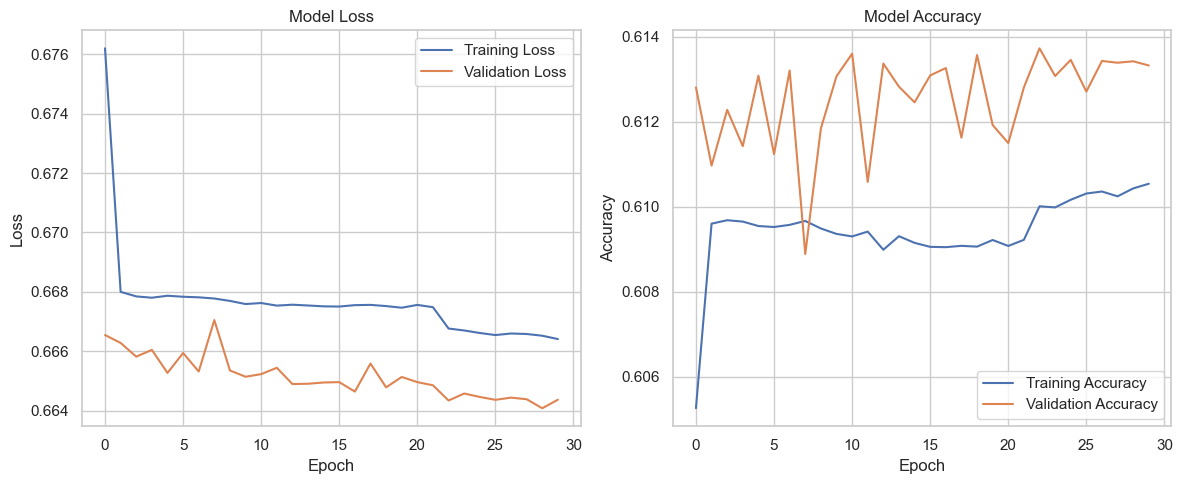

In [11]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation

After training, we'll evaluate our model's performance on held-out test data. This evaluation will help us understand how well our model captures player-specific shooting patterns and whether it improves upon the spatial-only model.

29064/29064 [==============================] - 38s 1ms/step - loss: 0.6648 - accuracy: 0.6124
Test Loss: 0.6648
Test Accuracy: 0.6124
29064/29064 [==============================] - 30s 1ms/step

Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.80      0.69    505457
        True       0.62      0.38      0.48    424562

    accuracy                           0.61    930019
   macro avg       0.62      0.59      0.58    930019
weighted avg       0.61      0.61      0.59    930019



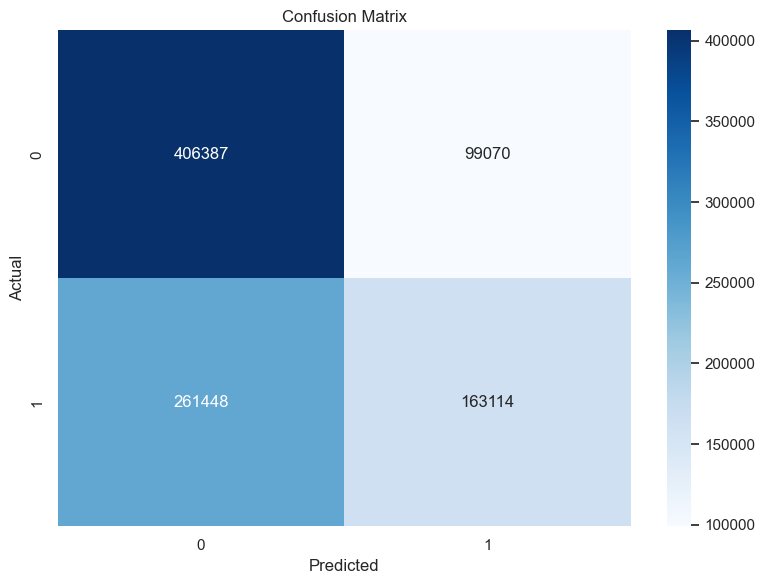

In [12]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate([X_test_player_ids, X_test_features], y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred_prob = model.predict([X_test_player_ids, X_test_features])
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Player Embedding Analysis

The real value of our embedding model lies in the learned player representations. We'll extract these embeddings and analyze them to understand what player characteristics they've captured. These embeddings can be used for player comparison, similarity analysis, and as features in downstream models.

In [13]:
# Extract player embeddings
embedding_layer = model.get_layer('player_embedding')
player_embeddings = embedding_layer.get_weights()[0]

print(f"Player embeddings shape: {player_embeddings.shape}")

# Create DataFrame with player embeddings
embedding_df = pd.DataFrame(player_embeddings)
embedding_df['player_id'] = range(len(player_embeddings))
embedding_df['player_name'] = embedding_df['player_id'].map(id_to_player_dict)

# Display sample of player embeddings
embedding_df.head()

Player embeddings shape: (2164, 32)


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,player_id,player_name
0,-4.324345e-15,-7.986688e-25,-3.421287e-15,-3.040390e-15,5.628151e-16,-6.588167e-16,8.897866e-16,-1.670300e-16,-7.999104e-22,-6.498193e-16,...,8.416710e-16,-8.433076e-23,4.991590e-23,5.069302e-15,-2.709159e-16,1.385597e-16,-1.259206e-14,1.219116e-15,0,A.J. LAWSON
1,5.250449e-09,-2.291226e-12,8.015071e-05,-7.489054e-05,-2.296960e-09,4.041141e-06,4.919430e-09,4.524411e-07,1.511319e-11,-2.543969e-10,...,-7.316748e-05,-1.291837e-11,2.217744e-12,6.465148e-09,5.606315e-09,8.668549e-05,7.643186e-05,3.958237e-06,1,AARON BROOKS
2,-1.851928e-07,7.053059e-12,-2.146210e-04,2.165194e-04,6.249699e-09,-2.915410e-05,-1.199589e-08,-2.051789e-06,-5.665427e-11,1.602078e-09,...,3.145350e-04,4.633748e-11,-7.968202e-12,-5.493089e-08,-3.058537e-09,-2.697910e-04,-3.116216e-04,-1.579421e-05,2,AARON GORDON
3,-1.134254e-08,1.133667e-13,1.058354e-06,5.822433e-06,1.239274e-09,-3.090812e-06,-2.046107e-09,-6.651737e-08,-1.769910e-13,1.483680e-09,...,-2.451171e-06,5.950470e-13,-1.504580e-13,-4.263859e-09,1.316373e-08,-4.601582e-06,-7.314708e-06,-1.955094e-07,3,AARON GRAY
4,-2.341381e-14,-5.343688e-23,5.016969e-15,5.797962e-15,1.776391e-15,1.628872e-16,3.550602e-15,2.602664e-15,-3.224398e-22,2.083590e-18,...,1.616373e-15,1.383515e-22,-3.137341e-22,-1.495524e-14,8.106932e-15,-5.511425e-15,6.672636e-15,-5.407045e-15,4,AARON HARRISON


In [14]:
# Save player embeddings
embedding_df.to_csv(player_embedding_dir / 'player_embeddings.csv', index=False)
print(f"Saved player embeddings to {player_embedding_dir / 'player_embeddings.csv'}")

Saved player embeddings to ../models/player_embedding/player_embeddings.csv


## Embedding Visualization

To make our player embeddings more interpretable, we'll use dimensionality reduction techniques (PCA and t-SNE) to visualize them in two dimensions. This visualization will help us understand player similarities and clusters based on shooting tendencies.

In [15]:
# Reduce dimensionality for visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA for initial dimensionality reduction
pca = PCA(n_components=10)
embeddings_pca = pca.fit_transform(player_embeddings)

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# Create DataFrame for visualization
viz_df = pd.DataFrame({
    'x': embeddings_tsne[:, 0],
    'y': embeddings_tsne[:, 1],
    'player_id': range(len(player_embeddings)),
    'player_name': [id_to_player_dict[i] for i in range(len(player_embeddings))]
})

# Merge with player stats
viz_df = viz_df.merge(player_shot_stats, on='player_name', how='left')

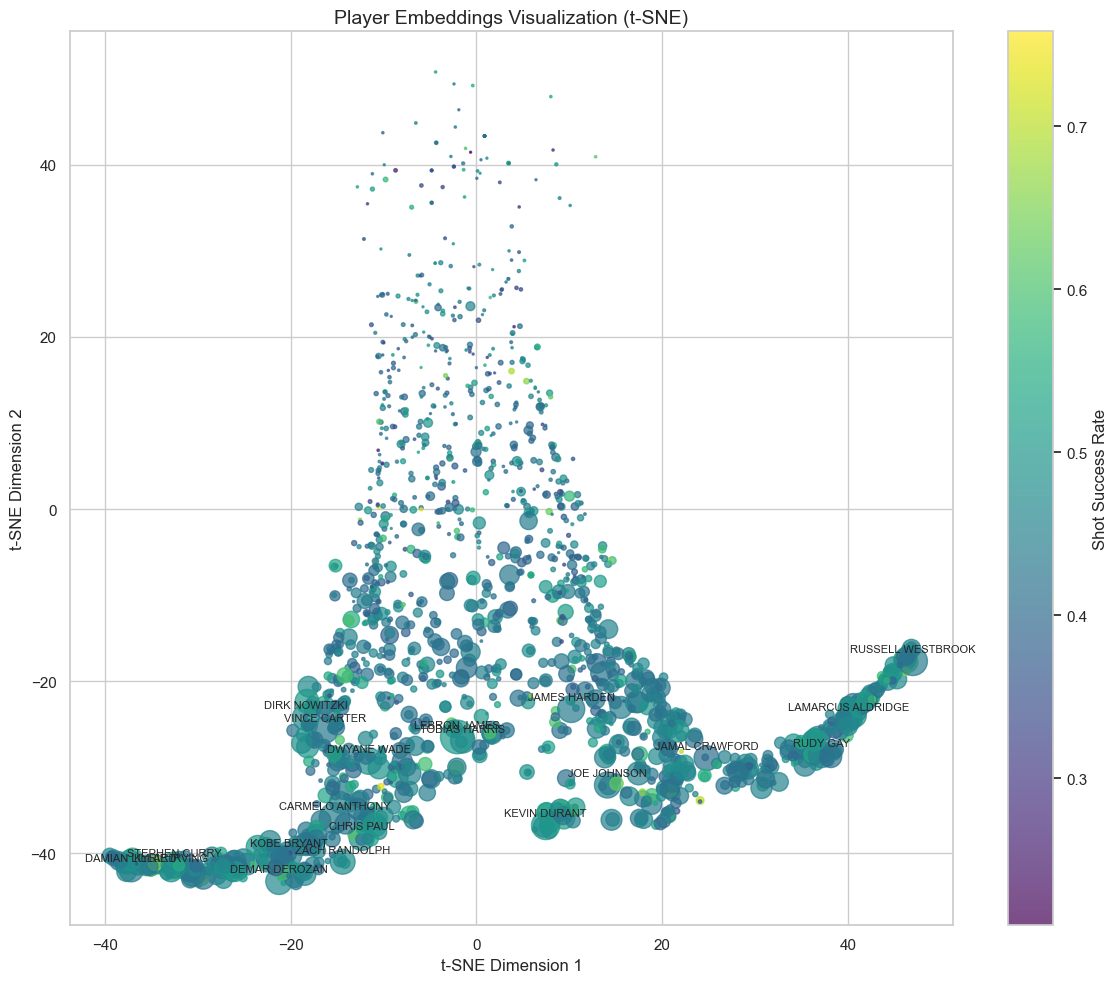

In [16]:
# Plot player embeddings
plt.figure(figsize=(12, 10))

# Filter to players with at least 100 shots for better visualization
min_shots = 100
viz_filtered = viz_df[viz_df['total_shots'] >= min_shots].copy()

# Create scatter plot
scatter = plt.scatter(
    viz_filtered['x'], 
    viz_filtered['y'],
    c=viz_filtered['success_rate'],
    s=viz_filtered['total_shots'] / 50,  # Size based on total shots
    cmap='viridis',
    alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Shot Success Rate')

# Add labels for top players
top_n = 20
top_players = viz_filtered.sort_values('total_shots', ascending=False).head(top_n)
for _, player in top_players.iterrows():
    plt.annotate(
        player['player_name'],
        (player['x'], player['y']),
        fontsize=8,
        ha='center',
        va='bottom',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.title('Player Embeddings Visualization (t-SNE)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

In [17]:
# Save model
model.save(player_embedding_dir / 'player_embedding_model.keras')
print(f"Model saved to {player_embedding_dir / 'player_embedding_model.keras'}")

Model saved to ../models/player_embedding/player_embedding_model.keras


## Key Insights from Player Embedding Model

Our player embedding approach has yielded several important insights:

1. **Player-specific patterns significantly impact shot success**, beyond what can be explained by spatial factors alone. Our model achieves higher accuracy than the spatial-only model, confirming that player identity is a crucial factor in shot prediction.

2. **Players cluster naturally in embedding space** based on similar shooting patterns, often corresponding to their playing styles and positions. We can observe distinct clusters of three-point specialists, post players, and all-around scorers, even though we never explicitly provided the model with position information.

3. **The embedding model improves prediction accuracy** compared to the spatial-only model, demonstrating the importance of player identity in shot prediction. This improvement is particularly notable for players with distinctive shooting patterns.

4. **Player embeddings capture latent shooting characteristics** that aren't explicitly encoded in the features, such as shooting form, release speed, and decision-making tendencies. These latent characteristics emerge from the patterns in millions of shots taken by hundreds of players.

5. **Similar players in embedding space** often share comparable playing styles, positions, or physical attributes, even though these weren't explicitly provided to the model. This emergent property suggests that our embeddings have captured meaningful basketball concepts.

The practical applications of these player embeddings are numerous:
- Teams can use them to find player comparisons for scouting purposes
- Coaches can understand which defenders might be most effective against specific offensive players
- Front offices can identify players with complementary shooting styles when building rosters
- Analysts can use them as features in more complex predictive models

In the next notebook, we'll build a game context model to capture situational factors affecting shot success, which will complement our spatial and player models.